## Lecture 10: Structural equation modeling

In this lecture we will focus on the estimation of parameters for SEM models.  We will use the *lavaan* R package for SEM analysis - there are Python-based packages, but they are not as widely accepted as lavaan. This will also highlight the utility of the R-to-Python bridge provided by Jupyter and the rpy2 package.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML
import rpy2
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()
import seaborn as sns

%load_ext rpy2.ipython

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## Linear regression

We will start by showing how one can estimate a simple linear regression model using SEM.  We will use simulated data so that we know the ground truth.

First, let's generate some data.

,x,Y
x,1.000000,0.480377
Y,0.480377,1.000000


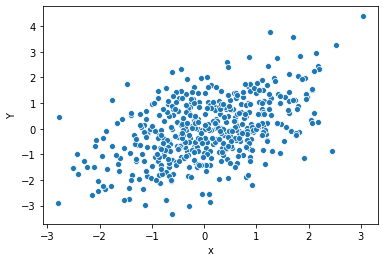

In [3]:
npts = 500
noise_sd = 1
rng = np.random.RandomState(1)
simdataDf = pd.DataFrame({'x': rng.randn(npts)})
beta = np.array([0.5])
simdataDf['Y'] = simdataDf.dot(beta) + np.random.randn(npts)*noise_sd

sns.scatterplot(x='x', y='Y', data=simdataDf)
simdataDf.corr()

In [4]:
# estimate linear regression model

X = sm.add_constant(simdataDf[['x']])
y = simdataDf['Y']
model = sm.OLS(y, X)
ols_results = model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     149.4
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           3.15e-30
Time:                        20:12:46   Log-Likelihood:                -725.91
No. Observations:                 500   AIC:                             1456.
Df Residuals:                     498   BIC:                             1464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0811      0.046     -1.748      0.0

Now let's build a structural model for this analysis using lavaan.

In [5]:
%%R -i simdataDf -o results

library(lavaan)
myModel <- ' # regressions
             Y ~ x
    
             # variances and covariances 
             Y ~~ Y 

             # intercepts 
             Y~ 1 
           '

fit <- lavaan(myModel, data=simdataDf)
summary(fit, standardized=TRUE)

results = list(fitted = fitted(fit)$cov,
              resid = resid(fit)$cov,
              coefs = coef(fit))

R[write to console]: This is lavaan 0.6-5

R[write to console]: lavaan is BETA software! Please report any bugs.



lavaan 0.6-5 ended normally after 10 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          3
                                                      
  Number of observations                           500
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  Y ~                                                                   
    x                 0.573    0.047   12.247    0.000    0.573    0.480

Intercepts:

$cov
  Y     x    
Y 1.388      
x 0.559 0.977

$mean
     Y      x 
-0.050  0.053 



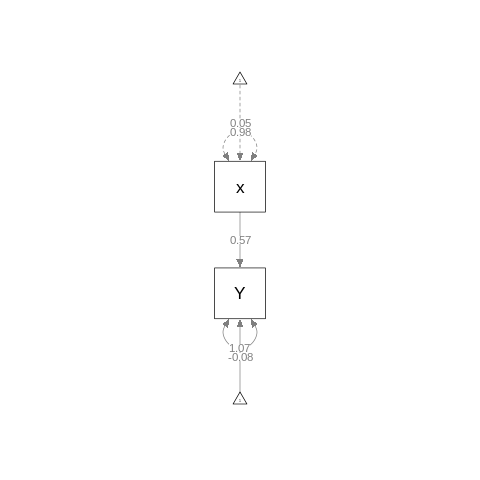

In [11]:
%%R
library(semPlot)

semPaths(fit, "model", "est", rotation=1, sizeMan =10, sizeMan2 = 10, 
        edge.label.cex = 1)

fitted(fit)

As you can see, the estimated parameters from SEM are the same as the regression model. However, the standard errors are very slightly different (not noticable to the third decimal place in this case) - this is because the OLS regression estimates using the unbiased estimator for the variance (with N-1 in the denominator), whereas SEM uses maximum likelihood which is a biased estimator of the variance (with N in the denominator).  These differences are minor unless the sample size is very small.



## Estimating SEM parameters

We saw in the earlier session on regression how those parameters are estimated using least squares.  SEM models are estimated in a different way.  Most importantly, the main difference between SEM and regression is the loss function: Whereas in linear regression we used the sum of squared errors between the predicted and estimated values for the data points, in SEM we use the sum of squared differences between the observed covariance and the covariance predicted by the model. For this reason, these models are often referred to as "covariance structure models".

The observed covariance between all measured variables serves as our estimate of the population covariance, which we simply plug into the loss function.  We compare this to the covariance matrix that is implied by any specific set of parameter values. 

Let's see how this works for the simple regression example, where we only have a single parameter.  The implied covariance matrix here is:



| $\sigma^2(x)$  |                | 
| ------------- | -------------  |
| $cov(x*\beta_1,x)$    |  $\sigma^2(y)$  |  


In [21]:
S = simdataDf.cov().values
print('observed covariance')
print(S)

observed covariance
[[0.9789087  0.56058198]
 [0.56058198 1.39114108]]


Let's create a function to generate the implied covariance from this dataset, given a specific value of $\beta_1$:

In [22]:
def get_implied_cov(dataDf, beta):
    # get observed cov
    observed = np.cov(dataDf.values.T)
    # get diagonal from observed
    sigma = np.zeros(observed.shape)
    sigma[np.diag_indices_from(observed)] = np.diag(observed)
    
    # get implied 
    sigma[0, 1] = np.cov(dataDf.x*beta, dataDf.x)[0, 1]
    sigma[1, 0] = sigma[0, 1]
    return(sigma)

sigma = get_implied_cov(simdataDf, ols_results.params.x)
print('model-implied covariance')
print(sigma)

model-implied covariance
[[0.9789087  0.56058198]
 [0.56058198 1.39114108]]


In this case the model-implied differs from the observed covariance matrix at one location (since the variances of x and y remain the same), which is the covariance of predicted values (using $\beta_1$) with the observed values.

## Loss function

Why are we worried about covariances?  Because whereas the squared error loss for ordinary least squares compares the predicted and observed *data*, the loss function for structural equation modeling compares the predicted and observed *covariances*.  Here is the loss function that is used for maximum likelihood estimation (rearranged from Bollen, 1989):

$$
F_{ML}(\theta) = log |\Sigma| - log|\textbf{S}| + tr(\textbf{S}\Sigma^{-1}) - (p + q)
$$

where:

- $log |\Sigma|$ is the log determinant of the implied covariance matrix 
- $log |\textbf{S}|$ is the log determinant of the observed covariance matrix 
- $tr(\textbf{S}\Sigma^{-1})$ is the trace of a matrix obtained by multiplying the observed covariance matrix by the inverse of the implied covariance matrix - basically this is a sum of the ratios of the observed and implied variances; in a simple model like this one, it is simply the number of variables, since the implied and observed variances are identical.
- p is the number of endogenous (dependent) variables
- q is the number of exogenous (independent) variables

Why do we take the determinant of the covariance matrix?  This basically tells us how dispersed our data are. Remember that the determinant of a 2 x 2 matrix:

$$
x = \left[ \begin{array}{cc}
a & b \\
c & d \\
\end{array} \right]
$$

is:

$$
|x| = a*d - b*c
$$

In the case of a covariance matrix, $a$ and $d$ are the variances, and $b$ and $c$ are the covariance, so the determinant is effectively the square of the variances minus the square of the covariances.  Also note that the determinant of a covariance matrix is always positive because the covariance matrices are positive definite. Thus, the determinant will be zero if the covariance is one, whereas the determinant will be maximal when the covariance is zero, and minimal (zero) when the correlation is perfect (either positive or negative):

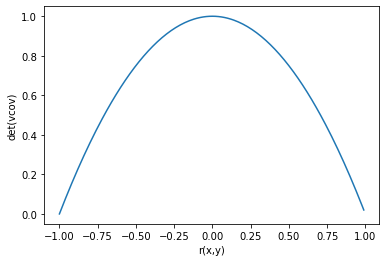

In [23]:
nruns=1000
npts=100
detsimDf = pd.DataFrame({'r': np.arange(-1, 1, 0.01)})

for i in range(detsimDf.shape[0]):
    r = detsimDf.r[i]
    vcov = np.array([[1, r], [r, 1]])
    detsimDf.loc[i, 'det'] = np.linalg.det(vcov)
    
plt.plot(detsimDf.r, detsimDf.det)
plt.xlabel('r(x,y)')
plt.ylabel('det(vcov)')
plt.savefig('det_vs_corr.pdf')


We see that the log determinant is at its minimum when the data are perfectly correlated; in the context of modeling, this means that the better our model, the more of the variance in the data we capture and thus the smaller the difference between the log determinant of the model-implied covariance and the sample covariance.  

Now let's generate a function to compute the loss, given particular implied and observed covariance functions:

In [34]:
def f_ml(cov_est, implied, verbose=False):
    log_det_implied = np.log(np.linalg.det(implied) )
    if verbose:
        print('log(det) for implied:', log_det_implied)
    cov_ratio_trace = np.trace(cov_est.dot(np.linalg.inv(implied)))
    if verbose:
        print('trace of variance ratios:', cov_ratio_trace)
    log_det_observed = np.log(np.linalg.det(cov_est))
    if verbose:
        print('log(det) for observed:', log_det_observed)
    F_ml = log_det_implied + cov_ratio_trace - log_det_observed - cov_est.shape[0]
    return(F_ml)

f_ml(S, sigma, verbose=True)

log(det) for implied: -1.2740884971649395
trace of variance ratios: 5.568078850876492
log(det) for observed: 0.0464521563926683


2.2475381973188844

Now let's try various values for the regression parameter and compute their loss:

Parameter with minimum loss: 0.5726601219749525
OLS estimate of parameter: 0.5726601219749528


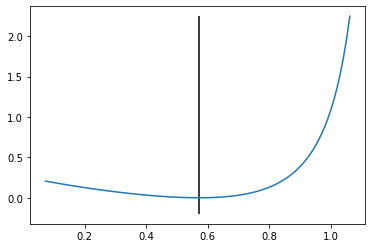

In [35]:
offset = 0.5
params = np.arange(ols_results.params.x - offset, ols_results.params.x + offset, 0.01)
loss_values = np.zeros(params.shape[0])
for i, beta in enumerate(params):
    sigma = get_implied_cov(simdataDf, beta)
    loss_values[i] = f_ml(S, sigma)
    
plt.plot(params, loss_values)
plt.vlines(ols_results.params.x, ymin=np.min(loss_values) - 0.2, ymax=np.max(loss_values))
print('Parameter with minimum loss:', params[np.argmin(loss_values)])
print('OLS estimate of parameter:', ols_results.params.x)

assert np.allclose(params[np.argmin(loss_values)], ols_results.params.x)

# A slightly more complex model

For this example, let's use a slightly more complex model, where we have a causal chain relating two variables (after Bollen, 1989, p. 88):

$$
y_1 = \gamma_{11}*x_1 + \xi_1
$$

$$
y_2 = \beta_{21}*y_1 + \xi_2
$$

where $x$ is an independent variable, $y_1$ and $y_2$ are dependent variables, and $\xi_1$ and $\xi_2$ are *disturbances* (i.e. error variables).

In [11]:
noise_sd = [4, 6]
chainDf = pd.DataFrame({'x': np.random.randn(npts)})
chainDf['y1'] = chainDf.x * 1.5 + np.random.randn(npts)*noise_sd[0]
chainDf['y2'] = chainDf['y1'] * 3 + np.random.randn(npts)*noise_sd[1]
chainDf = chainDf[['y1', 'y2', 'x']]
chainDf.cov()

,y1,y2,x
y1,18.778761,56.522409,1.612106
y2,56.522409,206.186173,5.383139
x,1.612106,5.383139,0.997718


In [12]:
%%R -i chainDf -o results

library(lavaan)
myModel <- ' # regressions
             y1 ~ x
             y2 ~ y1
    
             # variances and covariances 
             y1 ~~ y1
             y2 ~~ y2

             # intercepts 
             y1 ~ 1 
             y2 ~ 1
           '

fit <- lavaan(myModel, data=chainDf)
summary(fit, standardized=TRUE)

results = list(fitted = fitted(fit)$cov,
              resid = resid(fit)$cov,
              coefs = coef(fit))

lavaan 0.6-5 ended normally after 35 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          6
                                                      
  Number of observations                           500
                                                      
Model Test User Model:
                                                      
  Test statistic                                 4.568
  Degrees of freedom                                 1
  P-value (Chi-square)                           0.033

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  y1 ~                                                                  
    x                 1.616   

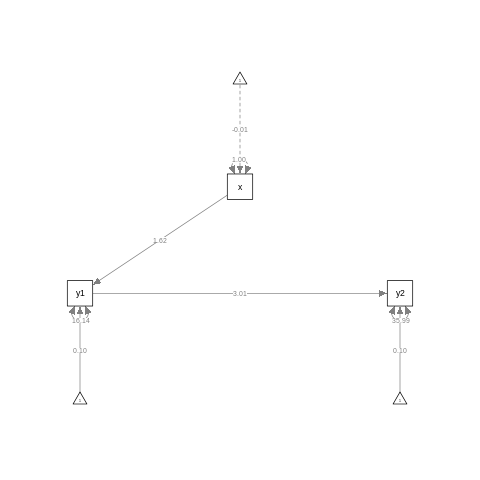

In [13]:
%%R

semPaths(fit, "model", "est")

In [14]:
implied, resid, coefs = np.array(results[0]), np.array(results[1]), np.array(results[2])
cov = resid + implied
cov

array([[ 18.74120332,  56.40936467,   1.60888187],
       [ 56.40936467, 205.77380104,   5.3723729 ],
       [  1.60888187,   5.3723729 ,   0.99572298]])

In [15]:
cov_est = np.cov(chainDf.T, bias=True)
cov_est
assert np.allclose(cov, cov_est)

In [16]:
print(results[2])

[ 1.61579264  3.00991157 16.14158384 35.98660184  0.09997267  0.10359135]


In [17]:
implied

array([[ 18.74120331,  56.40936463,   1.60888186],
       [ 56.40936463, 205.77380097,   4.84259212],
       [  1.60888186,   4.84259212,   0.99572298]])

In [18]:
# add Bollen's eq 4.15

In [19]:
# reconstruct the implied covariance matrix from the estimated parameters
def get_implied_cov(coefs, cov_est):
    my_implied = np.zeros(implied.shape)
    my_implied[0,0] = (coefs[0]**2) * cov_est[2,2] + coefs[2]
    my_implied[1, 0] = coefs[1]*(my_implied[0, 0])
    my_implied[2, 0] = coefs[0]*cov_est[2, 2]
    my_implied[1, 1] = (coefs[1]**2)*my_implied[0, 0] + coefs[3]
    my_implied[2, 1] = coefs[1]*coefs[0]*cov_est[2, 2]
    my_implied[2,2] = cov_est[2,2]

    my_implied[np.triu_indices_from(my_implied, 1)] = my_implied[np.tril_indices_from(my_implied, -1)]
    return(my_implied)

my_implied = get_implied_cov(coefs, cov_est)
assert np.allclose(my_implied, implied)

## Computing the loss

Now that we have seen how to compute the implied covariance matrix for a particular set of parameters, we can compute the loss function that is used for maximum likelihood estimation:

$$
F_{ML}(\theta) = log |\Sigma| + tr(\textbf{S}\Sigma^{-1}) - log|\textbf{S}| - (p + q)
$$

where p is the number of endogenous (dependent) variables, and q is the number of exogenous (independent) variables.


In [21]:
f_ml(cov_est, implied)

6.3602592946689
3.0183553197351753
6.351123493497318


0.027491120906756983

Let's try some various parameter values and look at the likelihood landscape:

In [22]:
y1xvals = np.arange(1, 1.12, .001)
y2y1vals = np.arange(2.98, 3.03, .001)

ml_est = np.zeros((y1xvals.shape[0], y2y1vals.shape[0]))
for i, p0 in enumerate(y1xvals):
    for j, p1 in enumerate(y2y1vals):
        sim_coefs = coefs.copy()
        sim_coefs[0] = p0
        sim_coefs[1] = p1
        sim_implied = get_implied_cov(sim_coefs, cov_est)
        ml_est[i, j] = f_ml(cov_est, sim_implied, verbose=False)



In [23]:
minloc = np.where(ml_est == np.min(ml_est))
print(y1xvals[minloc[0]])
print(y2y1vals[minloc[1]])

[1.12]
[2.996]


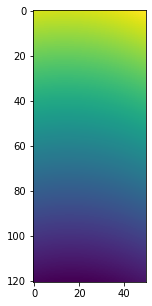

In [24]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(ml_est)


## Identification of SEMs



## Confirmatory factor analysis

One common use of structural equation modeling is for the estimation of *confirmatory factor analysis* models.  These models include a set of *indicator* variables, which reflect observed measurements.  Each indicator in a standard CFA model has two latent inputs: a single *factor* which is measured by that indicator, and an *error* term that represents the unique sources of variance for that indicator.  There can be multiple factors, which are allowed to correlate with one another.  

For standard CFA models (in which each observed variable is associated with a single latent factor), the identification requirements are simple: for a single factor there must be three indicators, and for two or more factors each factor must be associated with at least two indicators.

As an example, we will use the SRO dataset to fit a CFA model with three factors:

Impulsivity: measured by BIS-11 (nonplanning), Dickman (dysfunctional), and impulsive venturesomeness (impulsiveness) scores
Sensation seeking: measured by UPPS-P (sensation seeking), sensation seeking survey (thrill seeking), and BIS-BAS (fun seeking) scores
Goal-directedness: measured by Grit scale (grit), TIPS (conscientiousness), and UPPS-P (lack of perseverance) scores

Let's set up the model in lavaan:


In [25]:
from data_utils import get_SRO_data
SRO_data = get_SRO_data()
cfadata = SRO_data[['bis11_survey.Nonplanning',
                    'dickman_survey.dysfunctional',
                    'impulsive_venture_survey.impulsiveness',
                    'bis_bas_survey.BAS_fun_seeking',
                    'sensation_seeking_survey.thrill_adventure_seeking',
                    'upps_impulsivity_survey.sensation_seeking',
                    'upps_impulsivity_survey.lack_of_perseverance',
                    'ten_item_personality_survey.conscientiousness',
                    'grit_scale_survey.grit']].dropna()

In [26]:
%%R -i cfadata

cfa.model <- 'IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking
              GD =~ upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit'

fit <- cfa(cfa.model, data=cfadata)

summary(fit)

lavaan 0.6-5 ended normally after 51 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         21
                                                      
  Number of observations                           510
                                                      
Model Test User Model:
                                                      
  Test statistic                               348.645
  Degrees of freedom                                24
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  IMP =~                                              
    bs11_srvy.Nnpl    1.000                           
    dc

In [1]:
%%R
s = semPlotModel(fit)
m = modelMatrices(s)



UsageError: Cell magic `%%R` not found.


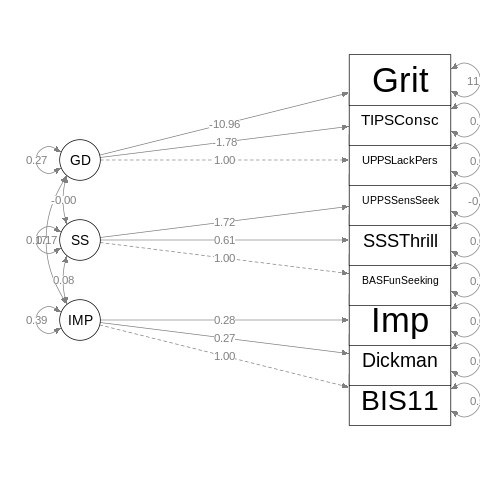

In [35]:
%%R

varnames = c('BIS11', 'Dickman', 'Imp', 'BASFunSeeking', 'SSSThrill', 
             'UPPSSensSeek', 'UPPSLackPers', 'TIPSConsc','Grit', "IMP" ,"SS",  "GD" )

semPaths(fit, "model", "est", 
         rotation=2, sizeMan =20, sizeMan2 = 10, 
         nodeLabels=varnames, edge.label.cex = 1)

## Model fit testing

blah blah blah

In [29]:
%%R

summary(fit, fit.measures=TRUE)

lavaan 0.6-5 ended normally after 51 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         21
                                                      
  Number of observations                           510
                                                      
Model Test User Model:
                                                      
  Test statistic                               348.645
  Degrees of freedom                                24
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              2927.019
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.888
  Tucker-Lewis Index (TLI)                       0.832

Loglikelihood and Information Criteri

...


## Model comparison



In [30]:
%%R

# fit a simpler two-factor model
cfa.model2 <- 'IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness + upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking '

fit2 <- cfa(cfa.model2, data=cfadata)

summary(fit2, fit.measures=TRUE)


lavaan 0.6-5 ended normally after 38 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         19
                                                      
  Number of observations                           510
                                                      
Model Test User Model:
                                                      
  Test statistic                               660.063
  Degrees of freedom                                26
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              2927.019
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.781
  Tucker-Lewis Index (TLI)                       0.696

Loglikelihood and Information Criteri

In [31]:
%%R 

library(semTools)

compareFit(fit, fit2)

R[write to console]:  

R[write to console]: ###############################################################################

R[write to console]: This is semTools 0.5-2

R[write to console]: All users of R (or SEM) are invited to submit functions or ideas for functions.

R[write to console]: ###############################################################################



################### Nested Model Comparison #########################
Chi-Squared Difference Test

     Df    AIC    BIC  Chisq Chisq diff Df diff Pr(>Chisq)    
fit  24 6722.5 6811.4 348.65                                  
fit2 26 7029.9 7110.4 660.06     311.42       2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

####################### Model Fit Indices ###########################
        chisq df pvalue   cfi   tli       aic       bic rmsea  srmr
fit  348.645† 24   .000 .888† .832† 6722.480† 6811.403† .163† .118†
fit2 660.063  26   .000 .781  .696  7029.898  7110.352  .219  .155 

################## Differences in Fit Indices #######################
           df    cfi    tli     aic     bic rmsea  srmr
fit2 - fit  2 -0.107 -0.135 307.418 298.949 0.056 0.037



## Cross-validation

We can also used cross-validation to assess the fit of a model to held-out data, using the same loss function that we used for fitting the model:


$$
F_{ML} = log |\Sigma(\theta)| + tr(\textbf{S}\Sigma^{-1}(\theta)) - log|\textbf{S}| - (p + q)
$$

To do this, let's create a python function that uses rpy2 to call lavaan:

In [32]:
pandas2ri.py2rpy(SRO_data[['Age']])
r('print(SRO_data)')

R[write to console]: Error in print(SRO_data) : object 'SRO_data' not found
Calls: <Anonymous> -> <Anonymous> -> print

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In lav_data_full(data = data, group = group, cluster = cluster,  :
R[write to console]: 
 
R[write to console]:  lavaan WARNING: some observed variances are (at least) a factor 1000 times larger than others; use varTable(fit) to investigate

R[write to console]: 2: 
R[write to console]: In lav_object_post_check(object) :
R[write to console]: 
 
R[write to console]:  lavaan WARNING: some estimated ov variances are negative

R[write to console]: 3: 
R[write to console]: In lav_data_full(data = data, group = group, cluster = cluster,  :
R[write to console]: 
 
R[write to console]:  lavaan WARNING: some observed variances are (at least) a factor 1000 times larger than others; use varTable(fit) to investigate

R[write to console]: 4: 
R[write to console]

RRuntimeError: Error in print(SRO_data) : object 'SRO_data' not found
Calls: <Anonymous> -> <Anonymous> -> print


In [ ]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

nruns = 10
test_proportion = .2

r('''
fml = function(observed, implied){
 log(det(observed)) - log(det(implied)) + sum(diag(solve(implied)%*%observed)) + length(diag(observed))
}''')

fml = r('''
library(lavaan)

cfa.model <- "IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking
              GD =~ upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit"
cfa.model2 <- "IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness + upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking "
cfa.model3 <- "SC =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness + upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit + bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking "

nruns = %d
testprop = %f
npts = nrow(cfadata)
idx = rep(0, npts)
idx[1:round(npts*testprop)] = 1
fmlresult = c()

for (i in 1:nruns){
    # split train/test
    idx = sample(idx)
    traindata = cfadata[idx==0,]
    testdata = cfadata[idx==1,]
    fit = cfa(cfa.model, data=traindata)
    fit2 = cfa(cfa.model2, data=traindata)
    fit3 = cfa(cfa.model3, data=traindata)


    test_cov = cov(testdata)
    train_cov = cov(traindata)
    implied_cov = fitted(fit)$cov
    fmlresult = rbind(fmlresult, c(fml(train_cov, fitted(fit)$cov), fml(train_cov, fitted(fit2)$cov), fml(train_cov, fitted(fit3)$cov),
            fml(test_cov, fitted(fit)$cov), fml(test_cov, fitted(fit2)$cov), fml(test_cov, fitted(fit3)$cov)))

}
''' % (nruns, test_proportion))


In [ ]:
%%R


apply(fmlresult, 2, mean)

In [ ]:
foo = r['data.frame'](cfadata)
foo

In [ ]:
r('dim(cfadata)')

In [ ]:
%%R

ls()

In [ ]:
newdata = cfadata.copy()
foo = r['data.frame'](newdata)
